In [5]:
import functions as f
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import importlib
importlib.reload(f)
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({
    'font.size': 14,             # base font size
    'axes.titlesize': 18,        # title
    'axes.labelsize': 16,        # x and y labels
    'xtick.labelsize': 12,       # tick labels
    'ytick.labelsize': 12,
    'legend.fontsize': 14,       # legend
    'figure.titlesize': 20, 
    'savefig.dpi': 300,
    'savefig.bbox':'tight'
    # 'figure.figsize': (23.4, 16.5, )       # figure title if using plt.suptitle
})

daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega\\"

# Results for diff returns (adjusted for inflation)

In [2]:
importlib.reload(f)
dataframes = f.load_data_pol(daily_omega)
df_concat = f.concat_and_select(dataframes, 0.99, cpi_file='CPI_POL.csv') #0.99
df_concat, index_series = f.calculate_returns(df_concat, 'diff')

% of stocks remaining: 12.50%
% of dates remaining: 99.89%
Number of stocks: 50
Number of dates: 3612
% of nans: 0.60%


<Axes: xlabel='Date'>

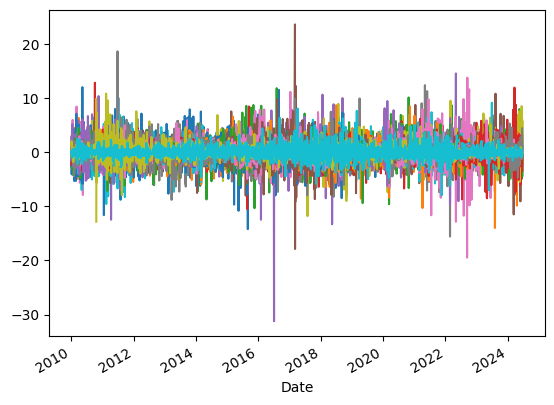

In [3]:
df_concat.plot(legend=False)

<I^2> = 0.1196
rho_0*sigma2_0 = 0.0666


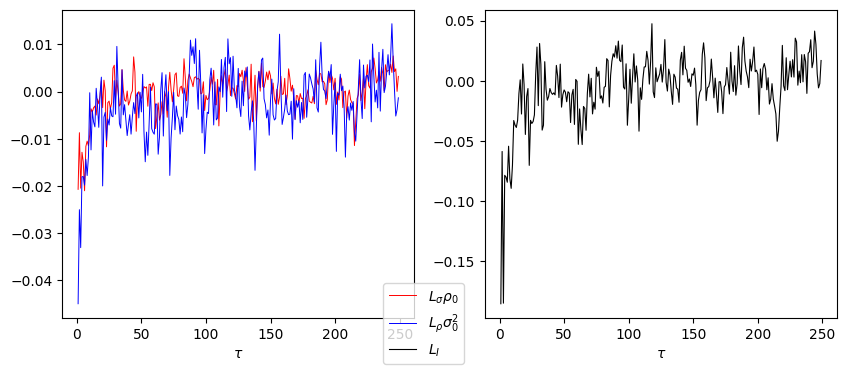

In [4]:
importlib.reload(f)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
data = f.calculate_correlation_functions(df_concat, index_series)

f.plot_correlation_functions(data, fig, ax)

# Results for log returns

[            06MAGNA
 Date               
 2000-11-17     3.96
 2000-11-20     3.98
 2000-11-21     4.05
 2000-11-22     3.92
 2000-11-23     3.95
 ...             ...
 2024-06-17     3.13
 2024-06-18     3.11
 2024-06-19     3.08
 2024-06-20     3.11
 2024-06-21     3.19
 
 [5510 rows x 1 columns],
              11BIT
 Date              
 2011-01-12    8.01
 2011-01-13    8.10
 2011-01-14    7.95
 2011-01-17    9.05
 2011-01-18    8.72
 ...            ...
 2024-06-17  631.00
 2024-06-18  676.00
 2024-06-19  655.00
 2024-06-20  639.00
 2024-06-21  631.00
 
 [3351 rows x 1 columns],
             1SOLUTION
 Date                 
 2022-01-26     1.3500
 2022-01-31     1.1200
 2022-02-01     1.1800
 2022-02-02     0.9802
 2022-02-03     0.7000
 ...               ...
 2024-06-17     0.1295
 2024-06-18     0.1260
 2024-06-19     0.1300
 2024-06-20     0.1280
 2024-06-21     0.1310
 
 [601 rows x 1 columns],
             3RGAMES
 Date               
 2021-01-19    1.010
 2021-01-20    1.040
 

In [2]:
importlib.reload(f)
dataframes = f.load_data_pol(daily_omega)

df_concat = f.concat_and_select(dataframes, min_non_na_fraction_col=0.1, min_non_na_fraction_row=0.0) #min nonna col 0.99
df_concat, index_series = f.calculate_returns(df_concat, 'log')


% of stocks remaining: 91.25%
% of dates remaining: 100.00%
Number of stocks: 365
Number of dates: 3616
% of nans: 41.84%


In [29]:
np.argmax(df_concat.columns=='BUDIMEX')

np.int64(86)

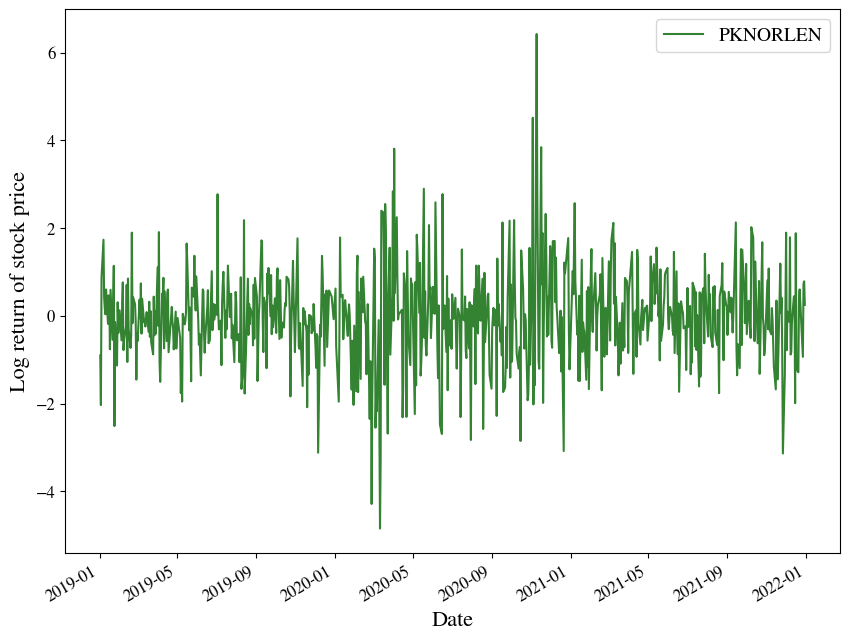

In [37]:
df_concat[['PKNORLEN']]['2019':'2021'].plot(alpha=0.8, ylabel='Log return of stock price', figsize=(10, 8), color='darkgreen').legend(loc='upper right')
plt.savefig('pol_log_returns3.png')

<I^2> = 0.0670
rho_0*sigma2_0 = 0.0355
rho_0 = 0.0355, sigma2_0 = 0.9999


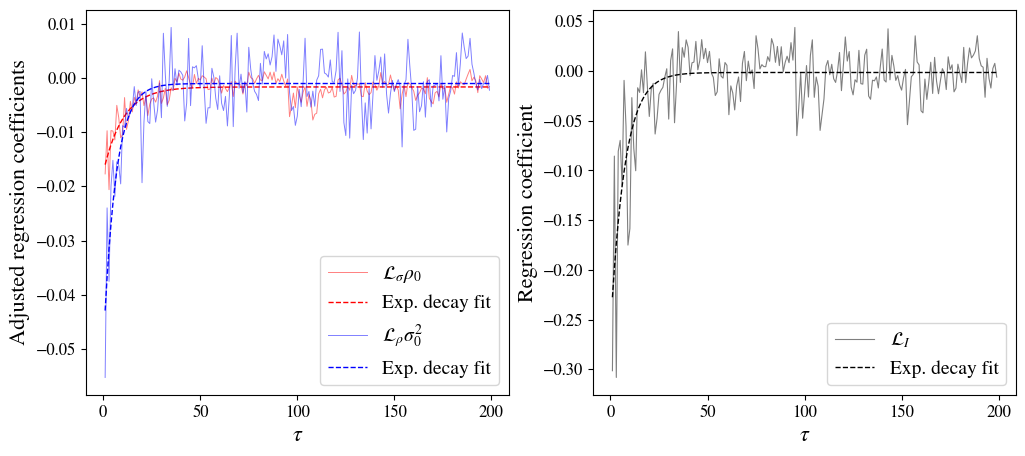

In [39]:
importlib.reload(f)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data = f.calculate_correlation_functions(df_concat, index_series)

f.plot_correlation_functions(data, fig, ax)
plt.savefig('pol_log_correlation_functions.png', bbox_inches='tight')

# With real index WIG

% of stocks remaining: 100.00%
% of dates remaining: 100.00%
Number of stocks: 1
Number of dates: 3609
% of nans: 0.03%
<I^2> = 0.9997
rho_0*sigma2_0 = 0.0355
rho_0 = 0.0355, sigma2_0 = 0.9999


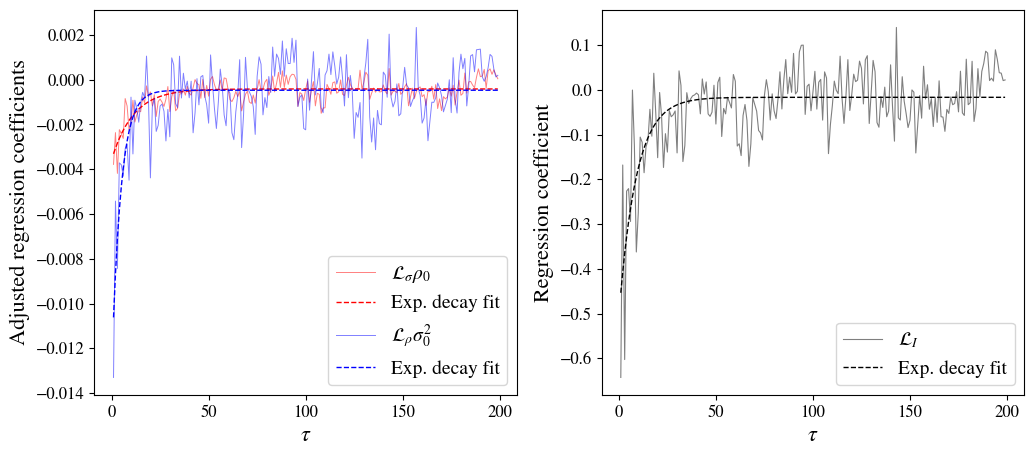

In [40]:
I = pd.read_csv('C:/physics_masters/data/Bossa public market data/pub/daily/omega/WIG.prn', delimiter=',', header=0, parse_dates=['Date'], usecols=['Date', 'Close'])
I.set_index('Date', inplace=True)
I.rename(columns={"Close": 'WIG'}, inplace=True)
I = f.concat_and_select([I])
I, _ = f.calculate_returns(I, 'log')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data = f.calculate_correlation_functions(df_concat, I['WIG'])

f.plot_correlation_functions(data, fig, ax)
plt.savefig('pol_log_correlation_functions_WIG.png', bbox_inches='tight')